# BASELINE - CBoW

In [1]:
!conda activate capp30255

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import torch
import torchtext
import torchdata
import portalocker

ModuleNotFoundError: No module named 'torchtext'

### Data Pre-processing

In [ ]:
# load data
train = pd.read_csv("./data/train.csv")
# check length of raw text 
train['length'] = train["comment_text"].apply(lambda x: len(x))
train['word_count'] = train["comment_text"].apply(lambda x: len(x.split(" ")))

In [ ]:
avg_wc = round(train['word_count'].mean())
pct_over60 = round(sum(train['word_count'] > 60)/len(train), 2)
pct_over100 = round(sum(train['word_count'] > 100)/len(train), 2)
pct_over200 = round(sum(train['word_count'] > 200)/len(train), 2)

print("The training dataset contains {} online comments.".format(len(train)))
print("The average length of the raw text is {} (measured by characters)".format(avg_wc))
print("The proportion of comments that has over 60 words: {}".format(pct_over60))
print("The proportion of comments that has over 100 words: {}".format(pct_over100))
print("The proportion of comments that has over 200 words: {}".format(pct_over200))

Check character count distribution

<Axes: ylabel='Frequency'>

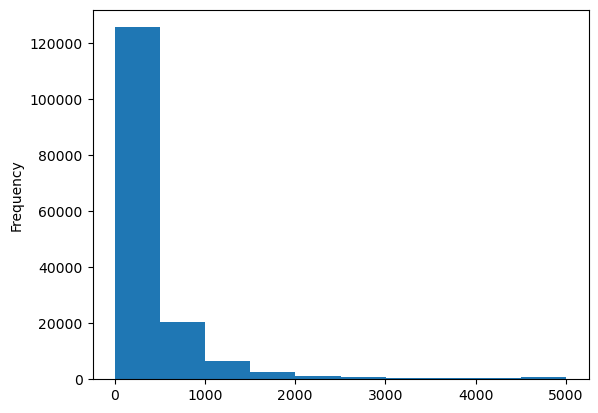

In [4]:
train['length'].plot.hist()

Check word count distribution for comments with no more than 200 words

<Axes: ylabel='Frequency'>

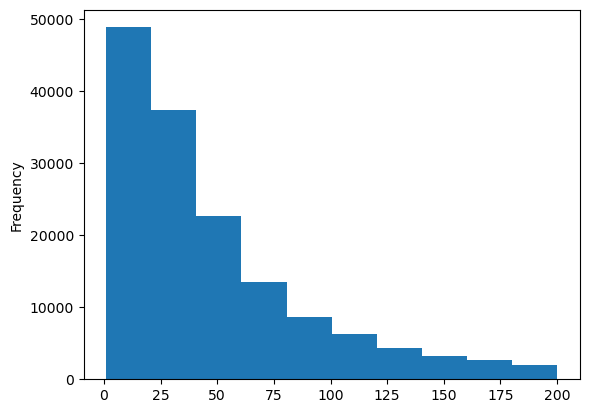

In [5]:
train['word_count'][train['word_count'] <= 200].plot.hist()

## Classes Dataset and DataLoader

Dataset and DataLoader are PyTorch classes that provides utilities for iterating through and sampling from a dataset. They provide several features for advanced applications (e.g., skim through [this tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) on writing custom datasets and dataloaders).

We'll work with the `` AG_NEWS`` dataset included within torchtext, and will write a custom dataloader to create minibatches of examples for training and testing.  The [``AG_NEWS``](https://rdrr.io/cran/textdata/man/dataset_ag_news.html) consists of about 120,000 examples of text from news sources, each labeled with one of 4 classes (world, sports, business, science and technology). 

In [7]:
train.head(10)

id                                       comment_text  toxic   
0  0000997932d777bf  Explanation\r\nWhy the edits made under my use...      0  \
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\r\nMore\r\nI can't make any real suggestions...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\r\n\r\nCongratulations from me as well, use ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  length  word_count  
0             0        0       0       0              0     265          42  
1             0        0       0       0              0     112          18  
2             0        0       0       0              0     233          42  
3             0        0       0       0              0     626         112  
4             0        0       0       0              0      67          13  
5             0        0       0       0              0      67          12  
6             1        1       0       1              0      44           8  
7             0        0       0       0              0     115          21  
8             0        0       0       0              0     472          83  
9             0        0       0       0              0      70          12

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data.iloc[index]
        # Extract the relevant columns from the CSV file
        text = sample["comment_text"]
        label = sample["toxic"]
        # Apply any transformations to the data
        if self.transform:
            text, label = self.transform(text, label)
        return text, label


In [ ]:
train_data = CustomDataset("./data/train.csv")
train_data[0]

# Build Vocab

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')

def yield_tokens(train_iter):
    for text, _ in train_iter:
        yield tokenizer(text)

# build vocab
vocab = build_vocab_from_iterator(
    yield_tokens(train_data), specials=["<unk>"], min_freq=1000)

In [ ]:
len(vocab)

In [ ]:
dft_idx = vocab['<unk>']
vocab.set_default_index(dft_idx)

In [ ]:
len(vocab)

In [ ]:

def collate_into_bow(batch):
    '''
    Create bag of words for a batch of comments
    Input: batch 
    Output: y: labels (0, 1)
            x: features (reletive frequency)
    '''

    k = len(batch)
    m = len(vocab)
    y = torch.zeros(k)
    x = torch.zeros(k, m)

    for i, (text, label) in enumerate(batch):

        # convert tokens into numeric features
        features = [vocab[tk] for tk in tokenizer(text)]

        # get relevant frequencies for each token
        freqs = torch.zeros(m)
        for idx in features:
            if idx != 0:
                freqs[idx] += 1
        freqs = freqs / freqs.sum()
        
        y[i] = label
        y = y.type(torch.LongTensor)
        x[i] = freqs

    return x, y

In [ ]:
# create DataLoader object with batchsize = 16
dataloader = DataLoader(train_data, batch_size=16, shuffle=False, 
                        collate_fn=collate_into_bow)

# The label:    torch.Size([16]) 
# The feature:  torch.Size([16, 6246])

# Create Single Layer BoW Classifier Class


In [ ]:
from torch import nn
import torch.nn.functional as F

class BoWClassifier(nn.Module):

    def __init__(self, num_labels, vocab_size):
        super(BoWClassifier, self).__init__()
        self.linear = nn.Linear(vocab_size, num_labels)
    
    def forward(self, bow_vec):
        print(self.linear(bow_vec))
        return F.log_softmax(self.linear(bow_vec), dim=1)

In [ ]:
for idx, (text, label) in enumerate(dataloader):
    print(text)
    print(label)
    if idx == 0:
        break

The following creates a model object of the class BoWClassifier.




In [ ]:
num_labels = 2
vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)
model

In [ ]:
import time

loss_function = torch.nn.NLLLoss()

def train_an_epoch(dataloader, optimizer):
    model.train() # Sets the module in training mode.
    log_interval = 500
    num_nan_batch = 0

    for idx, (text, label) in enumerate(dataloader):
        model.zero_grad()
        log_probs = model(text)

        has_nan = torch.isnan(log_probs).any().item()
        if has_nan:
            num_nan_batch += 1
            # print(text)
            # print(label)
            continue

        loss = loss_function(log_probs, label)
        print("loss: ", loss)
        loss.backward()
        optimizer.step()
        if idx % log_interval == 0 and idx > 0:
            print(f'At iteration {idx} the loss is {loss:.3f}.')
        if idx % 5000 == 0 and idx > 0:
            print("Skip", num_nan_batch, "batches containing nan probability")
            break



In [28]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.0001)
train_an_epoch(dataloader, optimizer)

idx:  0
tensor([[-0.0079, -0.0282],
        [-0.0054, -0.0271],
        [-0.0061, -0.0302],
        [-0.0110, -0.0259],
        [-0.0071, -0.0255],
        [-0.0096, -0.0150],
        [-0.0063, -0.0249],
        [-0.0052, -0.0284],
        [-0.0070, -0.0329],
        [-0.0032, -0.0369],
        [-0.0118, -0.0261],
        [-0.0141, -0.0385],
        [-0.0080, -0.0308],
        [-0.0108, -0.0280],
        [-0.0135, -0.0296],
        [-0.0089, -0.0317]], grad_fn=<AddmmBackward0>)
log_prob:  tensor([[-0.6831, -0.7033],
        [-0.6823, -0.7041],
        [-0.6812, -0.7052],
        [-0.6857, -0.7006],
        [-0.6840, -0.7024],
        [-0.6905, -0.6958],
        [-0.6839, -0.7025],
        [-0.6816, -0.7048],
        [-0.6803, -0.7062],
        [-0.6764, -0.7101],
        [-0.6860, -0.7003],
        [-0.6811, -0.7054],
        [-0.6818, -0.7046],
        [-0.6846, -0.7018],
        [-0.6852, -0.7012],
        [-0.6818, -0.7046]], grad_fn=<LogSoftmaxBackward0>)
loss:  tensor(0.6857, grad

Traceback (most recent call last):
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/13/_vv4l8hs25j7w31755973xv00000gn/T/ipykernel_45516/3087163192.py", line 3, in <module>
    train_an_epoch(dataloader, optimizer)
  File "/var/folders/13/_vv4l8hs25j7w31755973xv00000gn/T/ipykernel_45516/945433066.py", line 9, in train_an_epoch
    for idx, (text, label) in enumerate(dataloader):
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 634, in __next__
    data = self._next_data()
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 678, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "/Users/yifuhou/anaconda3/envs/capp30255/lib/python3.10/site-packages/torch/utils/d

In [42]:
x = np.array([1,2,3,4,5])
x = x/x.sum()
x = torch.Tensor(x)
x

tensor([0.0667, 0.1333, 0.2000, 0.2667, 0.3333])

In [44]:
x = np.array([0,0,0,0,0])
x = x/x.sum()
x = torch.Tensor(x)
x

/var/folders/13/_vv4l8hs25j7w31755973xv00000gn/T/ipykernel_45516/3358969583.py:2: RuntimeWarning: invalid value encountered in divide
  x = x/x.sum()


tensor([nan, nan, nan, nan, nan])

In [43]:
F.log_softmax(x, dim=0)

tensor([-1.7472, -1.6805, -1.6139, -1.5472, -1.4805])

## Computing average accuracy on a validation set

**Task 7** [7]: Write a function ``get_accuracy`` to compute the average accuracy of the model for a given dataloader.  Your code should iterate through all the examples, for each find the predicted label with the highest probability, and count the number of examples in which this predicted label is correct.  It should then return the average accuracy. Remember that although most batches will have a fixed number of examples (the given batch size), the last batch may have fewer examples.  So you should explicitly count the number of examples in each batch.

In [50]:
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [82]:

def get_accuracy(dataloader):
    model.eval()
    with torch.no_grad():

        total_count = 0
        total_correct = 0
        
        for idx, (label, text) in enumerate(dataloader):
            total_count += len(label)
            log_probs = model(text)
            preds = torch.argmax(log_probs, dim=1)
            total_correct += sum(preds == label)

        return total_correct / total_count

## Create training, validation, and testing dataloaders

Since the original ``AG_NEWS`` has no valid dataset, we split the training
dataset into train/valid sets with a split ratio of 0.95 (train) and
0.05 (valid). Here we use
[``torch.utils.data.dataset.random_split``](https://pytorch.org/docs/stable/data.html?highlight=random_split#torch.utils.data.random_split)
function in PyTorch core library.

In [84]:
from torch.utils.data.dataset import random_split

BATCH_SIZE = 64 # batch size for training
  
train_valid_data, test_data = AG_NEWS()
train_valid_data = list(train_valid_data)
num_train = int(len(train_valid_data) * 0.95)
num_valid = len(train_valid_data) - num_train
train_data, valid_data = random_split(
    train_valid_data, [num_train, num_valid])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_bow)
valid_dataloader = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_bow)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_bow)

## Training

At iteration 500 the loss is 1.217.
At iteration 1000 the loss is 1.236.
At iteration 1500 the loss is 1.008.

After epoch 1 the validation accuracy is 0.524.

At iteration 500 the loss is 0.997.
At iteration 1000 the loss is 1.041.
At iteration 1500 the loss is 0.970.

After epoch 2 the validation accuracy is 0.730.

At iteration 500 the loss is 0.893.
At iteration 1000 the loss is 0.840.
At iteration 1500 the loss is 0.851.

After epoch 3 the validation accuracy is 0.740.

At iteration 500 the loss is 0.925.
At iteration 1000 the loss is 0.692.
At iteration 1500 the loss is 0.630.

After epoch 4 the validation accuracy is 0.737.

At iteration 500 the loss is 0.871.
At iteration 1000 the loss is 0.812.
At iteration 1500 the loss is 0.632.

After epoch 5 the validation accuracy is 0.744.

At iteration 500 the loss is 0.695.
At iteration 1000 the loss is 0.715.
At iteration 1500 the loss is 0.543.

After epoch 6 the validation accuracy is 0.794.

At iteration 500 the loss is 0.636.
At i

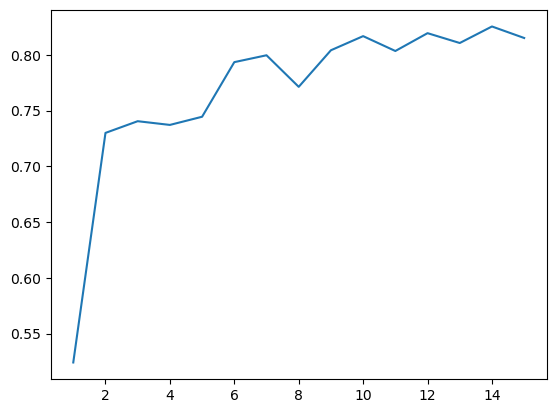

In [86]:
import matplotlib.pyplot as plt
%matplotlib inline

EPOCHS = 15 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

**Task 8** [10]: Run the model for a sufficient number of epochs such that the model shows overfitting, and submit a pdf of the plot of accuracy against number of epochs.  Determine the optimal number of epochs to train for.  Write code to estimate the accuracy of your model corresponding to this optimal number of epocs and report this estimated accuracy.

At iteration 500 the loss is 1.222.
At iteration 1000 the loss is 1.135.
At iteration 1500 the loss is 1.062.

After epoch 1 the validation accuracy is 0.652.

At iteration 500 the loss is 0.900.
At iteration 1000 the loss is 0.850.
At iteration 1500 the loss is 0.948.

After epoch 2 the validation accuracy is 0.715.

At iteration 500 the loss is 0.942.
At iteration 1000 the loss is 0.828.
At iteration 1500 the loss is 0.803.

After epoch 3 the validation accuracy is 0.758.

At iteration 500 the loss is 0.708.
At iteration 1000 the loss is 0.705.
At iteration 1500 the loss is 0.735.

After epoch 4 the validation accuracy is 0.744.

At iteration 500 the loss is 0.842.
At iteration 1000 the loss is 0.743.
At iteration 1500 the loss is 0.823.

After epoch 5 the validation accuracy is 0.761.

At iteration 500 the loss is 0.759.
At iteration 1000 the loss is 0.695.
At iteration 1500 the loss is 0.673.

After epoch 6 the validation accuracy is 0.793.

At iteration 500 the loss is 0.675.
At i

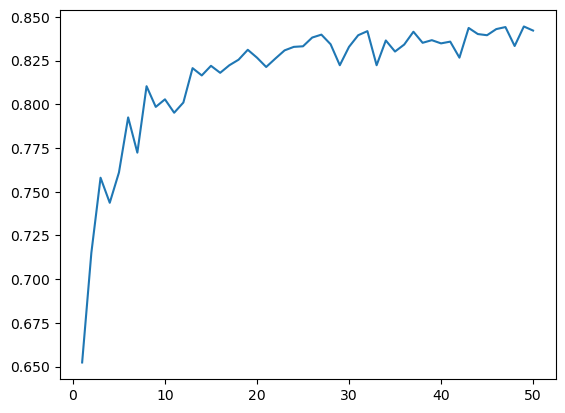

In [89]:
model = BoWClassifier(num_labels, vocab_size)

EPOCHS = 50 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    time_taken = time.time() - epoch_start_time
    print()
    print(f'After epoch {epoch} the validation accuracy is {accuracy:.3f}.')
    print()
    
plt.plot(range(1, EPOCHS+1), accuracies)

As the graph shows, after around 20 epochs, the validation accuracy reaches at a plateau with some fluctuations. If we keep running (which will take a very long time), it should start dropping due to overfitting. So we could confidently say taht 20 epochs is a good practice for this model.

In [91]:
model = BoWClassifier(num_labels, vocab_size)

OPT_EPOCHS = 20 # epoch
optimizer = torch.optim.SGD(model.parameters(), lr=3)

accuracies=[]
for epoch in range(1, OPT_EPOCHS + 1):
    train_an_epoch(train_dataloader, optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)

At iteration 500 the loss is 1.267.
At iteration 1000 the loss is 1.137.
At iteration 1500 the loss is 1.079.
At iteration 500 the loss is 1.077.
At iteration 1000 the loss is 0.959.
At iteration 1500 the loss is 0.829.
At iteration 500 the loss is 0.883.
At iteration 1000 the loss is 0.865.
At iteration 1500 the loss is 0.934.
At iteration 500 the loss is 0.748.
At iteration 1000 the loss is 0.787.
At iteration 1500 the loss is 0.704.
At iteration 500 the loss is 0.694.
At iteration 1000 the loss is 0.710.
At iteration 1500 the loss is 0.640.
At iteration 500 the loss is 0.747.
At iteration 1000 the loss is 0.656.
At iteration 1500 the loss is 0.771.
At iteration 500 the loss is 0.520.
At iteration 1000 the loss is 0.633.
At iteration 1500 the loss is 0.583.
At iteration 500 the loss is 0.604.
At iteration 1000 the loss is 0.721.
At iteration 1500 the loss is 0.558.
At iteration 500 the loss is 0.654.
At iteration 1000 the loss is 0.709.
At iteration 1500 the loss is 0.504.
At iterati

In [95]:
print("The estimated accuracy under optimal number of epochs (20) is: {}.".format(
    round(float(sum(accuracies)/len(accuracies)), 3)
))

The estimated accuracy under optimal number of epochs (20) is: 0.785.


**Task 9** [5]: Notice above that both the printed losses and the accuracies keep varying and do not necessary increase or decrease in a steady fashion.  List all the reasons you can think of for this variance in the loss and the accuracy.

##### 1. Small learning rate
We did not specify the learning rate of our model, so the weights may be changing too slow during training on each epoch. This will end up in a slow convergence, and the losses and accuracies will vary.

##### 2. Model structure
The neural network model we have so far is a single layer model. It might be too simple for such a task. Because the model is simple, it will take more time to pick up features and traits from data, and the losses and accuracies will vary due to constant underfit.

##### 3. Data Randomness 
For this task, we take a portion of the training data each time and train our model on it. Because the data is collected and embedded from natural language, it can be very random (or, the key features are not so prominent). So the performance of our model is not steadily improving with the increase of epochs.

## Adding a pre-trained embedding

[GloVe](https://nlp.stanford.edu/projects/glove/) is set of dense vector representations, or embeddings.  Torchtext has support for GloVe. (It takes several minutes the first time---to download.)

In [99]:
from itertools import combinations
from torchtext.vocab import GloVe

# It is best to save GloVe data in a cache to reuse across projects.
VECTOR_CACHE_DIR = './Desktop/glove/.vector_cache'

glove = GloVe(name='6B', cache = VECTOR_CACHE_DIR)

words = ["hello", "hi", "king", "president"]
vecs = glove.get_vecs_by_tokens(words)

print(vecs.shape)
print()
for (i, j) in combinations(range(4), 2):
    print(words[i], words[j], vecs[i].dot(vecs[j]))
print()
print(vecs)

torch.Size([4, 300])

hello hi tensor(13.7214)
hello king tensor(2.2427)
hello president tensor(2.7678)
hi king tensor(1.4366)
hi president tensor(-2.7832)
king president tensor(14.2624)

tensor([[-0.3371, -0.2169, -0.0066,  ...,  0.4056,  0.1807,  0.6425],
        [ 0.4084, -0.1843, -0.1757,  ..., -0.5265,  0.8163,  0.7427],
        [ 0.0034, -0.3461,  0.2814,  ...,  0.0821, -0.6880,  0.3027],
        [ 0.4367,  0.1879, -0.1702,  ...,  0.0329, -0.5214,  0.2229]])


In [177]:
vecs.mean(dim=0).shape

torch.Size([300])

**Task 10** [10]: Write a new collate function ``collate_into_cbow`` that returns a CBoW representation of each batch, using GloVe.



In [189]:
def collate_into_cbow(batch):
    
    k = len(batch)
    m = 300
    y = torch.zeros(k)
    x = torch.zeros(k, m)

    for i, (label, text) in enumerate(batch):
        tokens = tokenizer(text)
        features = glove.get_vecs_by_tokens(tokens)
        y[i] = label - 1
        # x[i] = features.mean(dim=0)
        x[i] = features

    y = y.type(torch.LongTensor)

    return y, x


**Task 11** [5]: Write copies of other functions as needed to determine the estimate accuracy of the (optimal) model that incorporates GloVe.

In [182]:
# # re-define dataloader
# dataloader_cbow = DataLoader(train_iter, batch_size=16, shuffle=False, 
#                         collate_fn=collate_into_cbow)

# re-build model 
num_labels = len(set([label for (label, text) in train_data]))
vocab_size = 300
model = BoWClassifier(num_labels, vocab_size)

# create new dataloader objects with CBoW

train_dataloader_cbow = DataLoader(train_data, batch_size=BATCH_SIZE,
                              shuffle=True, 
                              collate_fn=collate_into_cbow)
valid_dataloader_cbow = DataLoader(valid_data, batch_size=BATCH_SIZE,
                              shuffle=False, 
                              collate_fn=collate_into_cbow)
test_dataloader_cbow = DataLoader(test_data, batch_size=BATCH_SIZE,
                             shuffle=False, 
                             collate_fn=collate_into_cbow)


In [187]:
# get new accuracy

accuracies=[]
for epoch in range(1, OPT_EPOCHS + 1):
    train_an_epoch(train_dataloader_cbow, optimizer)
    accuracy = get_accuracy(valid_dataloader_cbow)
    accuracies.append(accuracy)
    
print("With GloVe embeddings, the estimated accuracy under optimal number of epochs (20) is: {}.".format(
    round(float(sum(accuracies)/len(accuracies)), 3)
))

At iteration 500 the loss is 1.402.
At iteration 1000 the loss is 1.401.
At iteration 1500 the loss is 1.412.
At iteration 500 the loss is 1.401.
At iteration 1000 the loss is 1.391.
At iteration 1500 the loss is 1.403.
At iteration 500 the loss is 1.402.
At iteration 1000 the loss is 1.420.
At iteration 1500 the loss is 1.402.
At iteration 500 the loss is 1.406.
At iteration 1000 the loss is 1.396.
At iteration 1500 the loss is 1.405.
At iteration 500 the loss is 1.419.
At iteration 1000 the loss is 1.409.
At iteration 1500 the loss is 1.405.
At iteration 500 the loss is 1.401.
At iteration 1000 the loss is 1.414.
At iteration 1500 the loss is 1.403.
At iteration 500 the loss is 1.405.
At iteration 1000 the loss is 1.405.
At iteration 1500 the loss is 1.400.
At iteration 500 the loss is 1.419.
At iteration 1000 the loss is 1.404.
At iteration 1500 the loss is 1.393.
At iteration 500 the loss is 1.402.
At iteration 1000 the loss is 1.415.
At iteration 1500 the loss is 1.420.
At iterati

In [190]:
# get new accuracy

model = BoWClassifier(num_labels, vocab_size)

accuracies=[]
for epoch in range(1, OPT_EPOCHS + 1):
    train_an_epoch(train_dataloader_cbow, optimizer)
    accuracy = get_accuracy(valid_dataloader_cbow)
    accuracies.append(accuracy)
    
print("With GloVe embeddings, the estimated accuracy under optimal number of epochs (20) is: {}.".format(
    round(float(sum(accuracies)/len(accuracies)), 3)
))

At iteration 500 the loss is 1.411.
At iteration 1000 the loss is 1.392.
At iteration 1500 the loss is 1.407.
At iteration 500 the loss is 1.378.
At iteration 1000 the loss is 1.423.
At iteration 1500 the loss is 1.402.
At iteration 500 the loss is 1.405.
At iteration 1000 the loss is 1.406.
At iteration 1500 the loss is 1.405.
At iteration 500 the loss is 1.407.
At iteration 1000 the loss is 1.415.
At iteration 1500 the loss is 1.401.
At iteration 500 the loss is 1.397.
At iteration 1000 the loss is 1.395.
At iteration 1500 the loss is 1.409.
At iteration 500 the loss is 1.402.
At iteration 1000 the loss is 1.413.
At iteration 1500 the loss is 1.410.
At iteration 500 the loss is 1.409.
At iteration 1000 the loss is 1.398.
At iteration 1500 the loss is 1.414.
At iteration 500 the loss is 1.406.
At iteration 1000 the loss is 1.413.
At iteration 1500 the loss is 1.419.
At iteration 500 the loss is 1.418.
At iteration 1000 the loss is 1.396.
At iteration 1500 the loss is 1.412.
At iterati

## Using the Adam optimizer

The [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam) is usually preferred to SGD because of better convergence properites.

**Task 12** [5]: Write copies of functions as needed to plot the convergence of the Adam optimizer.

In [200]:

vocab_size = len(vocab)
model = BoWClassifier(num_labels, vocab_size)
adam_optimizer = optim.Adam(model.parameters(), lr=0.1)

accuracies=[]
for epoch in range(1, OPT_EPOCHS + 1):
    train_an_epoch(train_dataloader, adam_optimizer)
    accuracy = get_accuracy(valid_dataloader)
    accuracies.append(accuracy)
    
print("With Adam optimization, the estimated accuracy under optimal number of epochs (20) is: {}.".format(
    round(float(sum(accuracies)/len(accuracies)), 3)
))

At iteration 500 the loss is 0.335.
At iteration 1000 the loss is 0.470.
At iteration 1500 the loss is 0.545.
At iteration 500 the loss is 0.295.
At iteration 1000 the loss is 0.363.
At iteration 1500 the loss is 0.359.
At iteration 500 the loss is 0.510.
At iteration 1000 the loss is 0.428.
At iteration 1500 the loss is 0.535.
At iteration 500 the loss is 0.363.
At iteration 1000 the loss is 0.296.
At iteration 1500 the loss is 0.566.
At iteration 500 the loss is 0.419.
At iteration 1000 the loss is 0.245.
At iteration 1500 the loss is 0.423.
At iteration 500 the loss is 0.354.
At iteration 1000 the loss is 0.425.
At iteration 1500 the loss is 0.326.
At iteration 500 the loss is 0.261.
At iteration 1000 the loss is 0.450.
At iteration 1500 the loss is 0.445.
At iteration 500 the loss is 0.295.
At iteration 1000 the loss is 0.518.
At iteration 1500 the loss is 0.536.
At iteration 500 the loss is 0.584.
At iteration 1000 the loss is 0.350.
At iteration 1500 the loss is 0.436.
At iterati

## Other Optimizations

**Task 13** [5]: Briefly desribe 3 ways by which you could make the above code run faster or improve its accuracy.  (You don't have to implement your suggestions.)

##### 1. Parallelization with GPU 
The code is repeating the same process to improve the model. One way to make it run faster is to use GPU to make the computation run in parallel.
##### 2. Use regularizations
By adding regularization to the model, we can add penalty on loss function to avoid overfitting. This will improve model's accuracy. 
##### 3. Adding more layers to neural network
The current Neural Network model only has one layer. To improve accuracy we could add more inner layers and create non0linear boundaries in our model. This is likely to improve the accuracy because the model can implement more complicated classifications.